# Loading Data via Generators

## Creating Generators

In [1]:
# define file paths to relevant data
trainingDataPath = "../behavioral_cloning_data/"
csvFilePath = trainingDataPath + "driving_log.csv"
imagesPath = trainingDataPath + "IMG/"

In [2]:
import numpy as np
from helper import plotImages
from generators import createGenerators
from keras.preprocessing.image import ImageDataGenerator

# create closure to help with debugging and visualizations
def generatorClosure(csvFilePath, imagesPath):
    def inner_func(data_gen_pp, count=3, title="", prepreprocessing=lambda x, y: (x, y), undo=lambda x: x):
        '''
            data_gen_pp       -> a keras.preprocessing.image.ImageDataGenerator object to be used with training data
            count             -> how much of the training data to use for this generator
            prepreprocessing  -> a function meant to run on the training x, y data before any preprocessing
            undo              -> a function to assist w/ visualization and undoing logic that would render an 
                                 image as unrecognizable when plotted (mostly to undo normalization)
        '''
        # create training set and validation set data generators
        train_generator, validation_generator, t_len, v_len = createGenerators(csvFilePath=csvFilePath, 
                                                                             imagesPath=imagesPath, 
                                                                             data_gen_pp=data_gen_pp,
                                                                             prepreprocessing=prepreprocessing,
                                                                             subsegment=count)
        
        generated_images = []
        for i in range(count):
            data = next(train_generator)
            generated_images.append(undo(np.array(data[0])[0]).astype('uint8'))
            
        plotImages(images=generated_images, titles=[title for i in range(count)], columns=3)
                                    
    return inner_func

# use the closure that was just defined
plotGenerator = generatorClosure(csvFilePath, imagesPath)

Using TensorFlow backend.


## Preprocessing Visualizations

In the next several cells, we will be visualizing what effects different preprocessing methods have on the input images

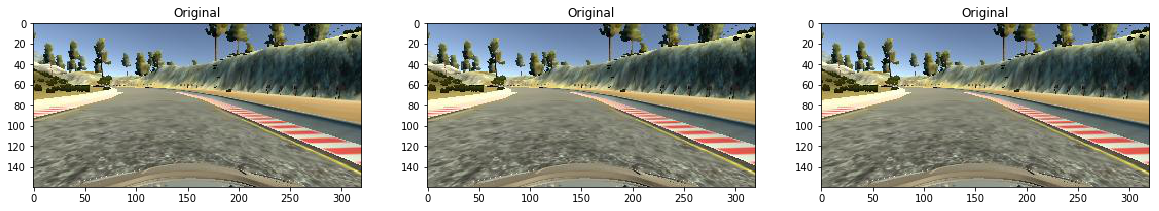

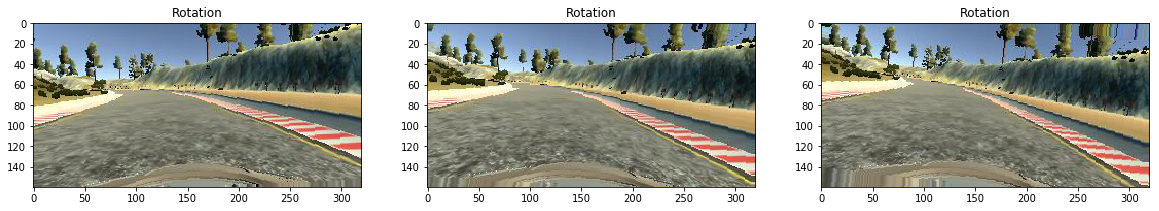

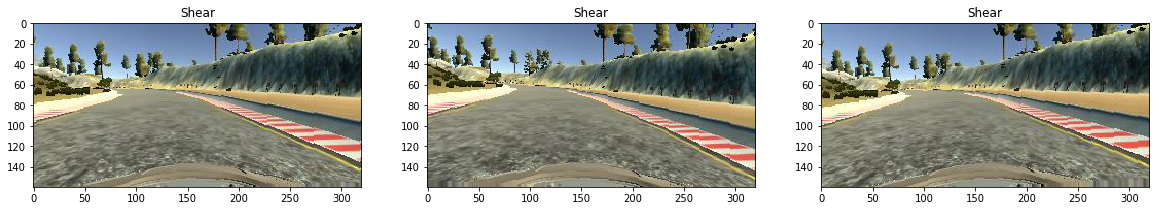

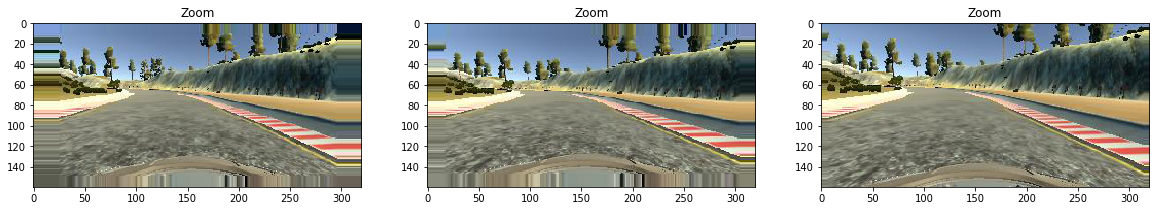

In [3]:
dataGenParams = {
    "rotation_range": 7,   
    "shear_range": 0.1,    
    "zoom_range": 0.2,   
    "horizontal_flip": True                                      
}

plotGenerator(ImageDataGenerator(),                                 title="Original")
plotGenerator(ImageDataGenerator(rotation_range=dataGenParams["rotation_range"]),  title="Rotation")
plotGenerator(ImageDataGenerator(shear_range=dataGenParams["shear_range"]),     title="Shear")
plotGenerator(ImageDataGenerator(zoom_range=dataGenParams["zoom_range"]),      title="Zoom")

# Note: Horizontal flip cannot be used here. It must be a pre-preprocessing step where the steering angle value
#       is also flipped.
# plotGenerator(ImageDataGenerator(horizontal_flip=dataGenParams["horizontal_flip"]), title="Horizontal Flip")

#plotGenerator(ImageDataGenerator(brightness_range=(0.5, 1.5)), title="Brightness")
#plotGenerator(ImageDataGenerator(vertical_flip=True), title="Vertical Flip")
#plotGenerator(ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1), title="Shift")

### Testing Different Preprocessing and Pre-Preprocessing Methods

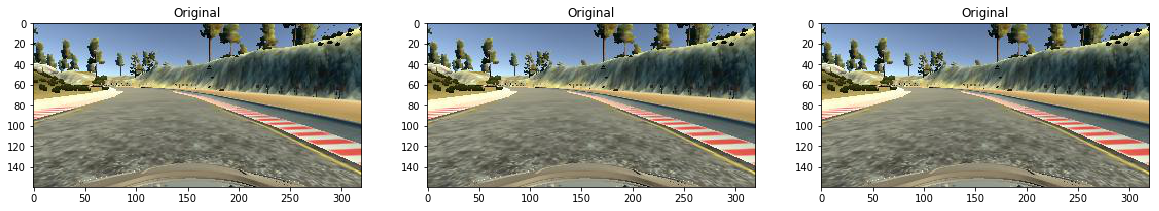

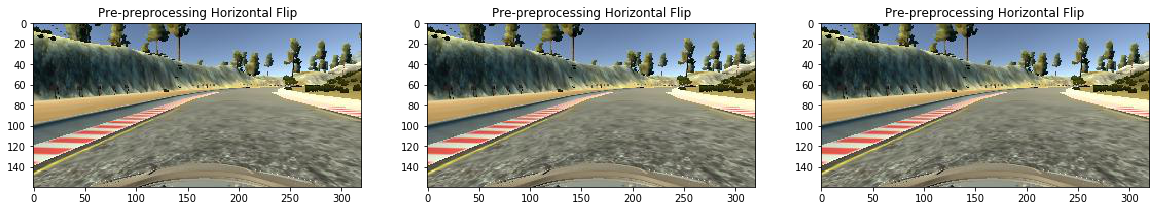

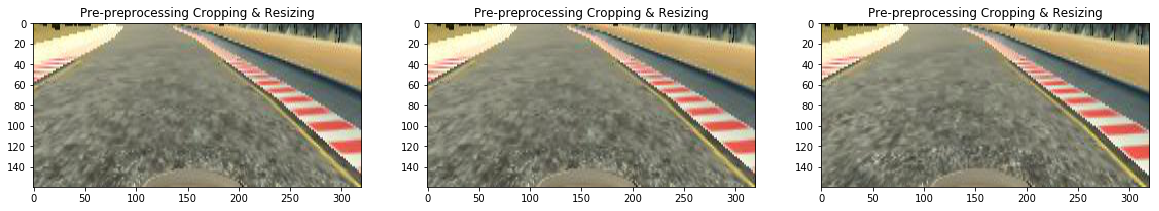

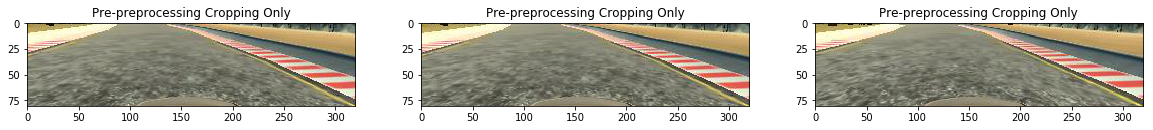

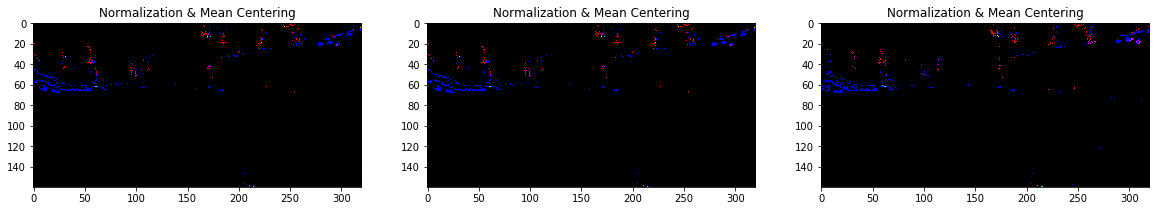

In [27]:
import cv2
from random import random

# normalize and zero mean center
def normalize(x):
    return x/127.5 - 1.    

def denormalize(x):
    return (x + 1.)*127.5

def crop(x, y):
    h, w, c = x.shape
    return x[h//12*5:h - h//11,0:w], y

def crop_no_label(x):
    return crop(x, 0)[0]

def crop_and_resize(x, y):
    h, w, c = x.shape
    x, y = crop(x,y)
    return cv2.resize(x, (w,h)), y

def horizontal_flip(x, y):
    '''
    x   -> the numpy multi-dimensional array image
    y   -> the float representing the steering angle
    '''
    return cv2.flip(x, 1), -1*y

def rand_horizontal_flip(x, y):
    '''
    x   -> the numpy multi-dimensional array image
    y   -> the float representing the steering angle
    
    Note: randomly flips the input half of the time
    '''
    # randomly flip
    if random() < 0.5:
        return horizontal_flip(x, y)
    else:
        return x, y
    
plotGenerator(ImageDataGenerator(), title="Original")
plotGenerator(ImageDataGenerator(), title="Pre-preprocessing Horizontal Flip", prepreprocessing=rand_horizontal_flip)
plotGenerator(ImageDataGenerator(), title="Pre-preprocessing Cropping & Resizing", prepreprocessing=crop_and_resize)
plotGenerator(ImageDataGenerator(), title="Pre-preprocessing Cropping Only", prepreprocessing=crop)
plotGenerator(ImageDataGenerator(preprocessing_function=normalize), title="Normalization & Mean Centering")

# assign the preprocessing step for this image preprocessor
dataGenParams["preprocessing_function"] = normalize
# combine pre-preprocessing methods
dataGenPrePreprocessing = lambda x, y: rand_horizontal_flip(*crop(x, y))

### Combining Preprocessing Methods

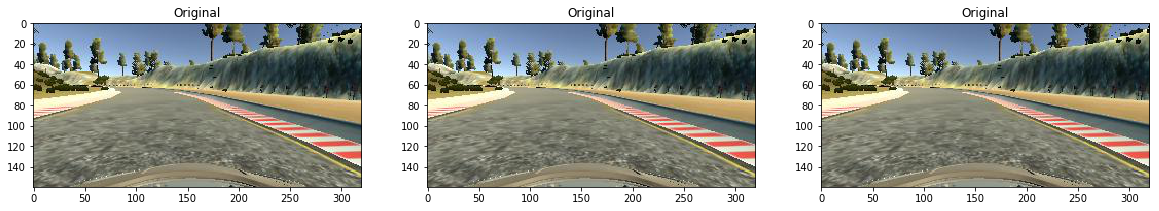

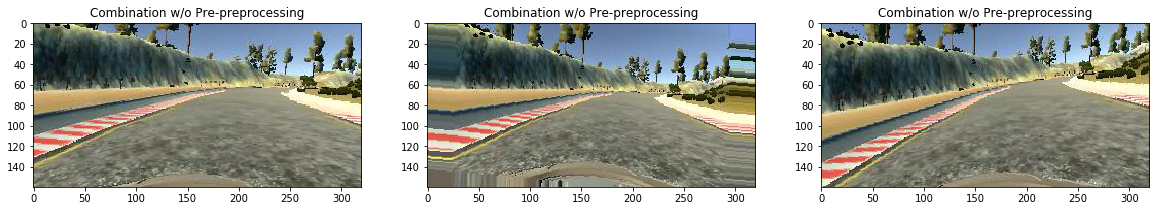

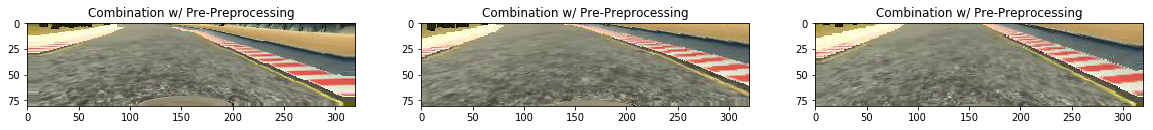

In [28]:
# drop fill_mode if there is one (can't assign the same value twice!)
dataGenParams.pop('fill_mode', None)

plotGenerator(ImageDataGenerator(), title="Original")
plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode="nearest"), 
              title="Combination w/o Pre-preprocessing",
              undo=denormalize)

plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode="nearest"), 
              title="Combination w/ Pre-Preprocessing",
              prepreprocessing=dataGenPrePreprocessing,
              undo=denormalize)

### Testing Different Fill Modes

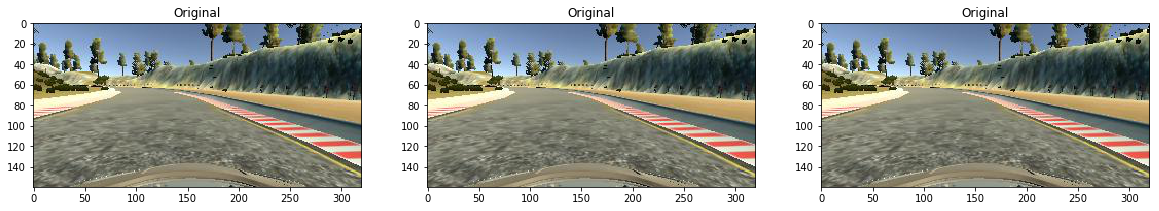

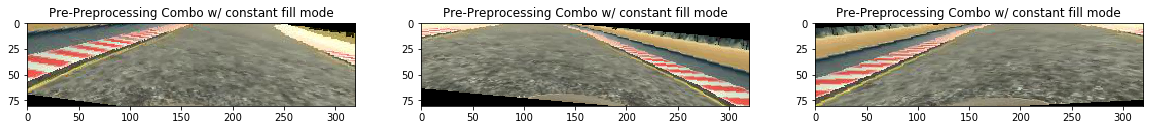

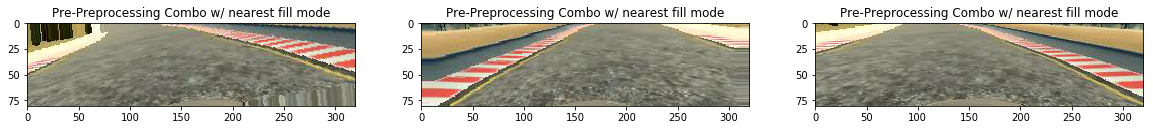

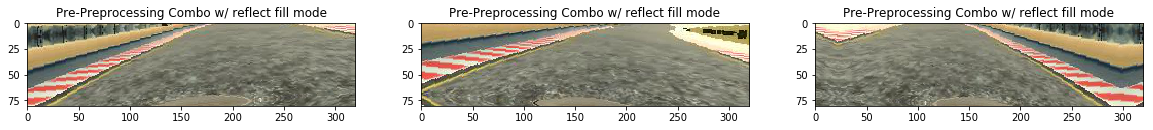

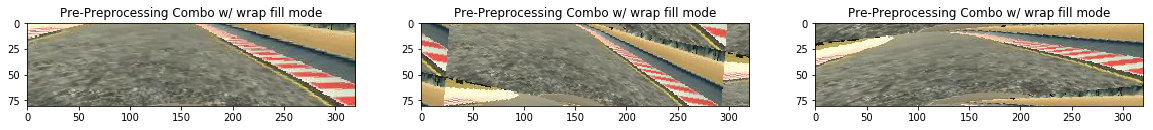

In [29]:
plotGenerator(ImageDataGenerator(), title="Original")

# drop fill_mode if there is one (can't assign the same value twice!)
dataGenParams.pop('fill_mode', None)

for fill_mode in ["constant", "nearest", "reflect", "wrap"]:
    plotGenerator(ImageDataGenerator(**dataGenParams, fill_mode=fill_mode), 
                  title="Pre-Preprocessing Combo w/ " + fill_mode + " fill mode",
                  prepreprocessing=dataGenPrePreprocessing,
                  undo=denormalize)

# assign what looks the best
dataGenParams["fill_mode"] = "nearest"

## Train Model

In [31]:
#from helper import update_log
%run helper.py
#from model import train_model
%run model.py
%run generators.py
# NOTE: The pre-preprocessing and preprocessing are for training images with labeled data
# So, we must combine the two for the preprocessing of REAL image data
def printX(x):
    print(x)
    return x

realPreprocessing = lambda x: printX(normalize(crop_no_label(x)))

# and we must remove the preprocessing_function on the image data generator
dataGenParams.pop("preprocessing_function", None)
# create training set and validation set data generators
batch_size = 32
train_generator, validation_generator, t_len, v_len = createGenerators(csvFilePath=csvFilePath, 
                                                                     imagesPath=imagesPath, 
                                                                     data_gen_pp=ImageDataGenerator(dataGenParams),
                                                                     batch_size=batch_size,
                                                                     subsegment=3)

history_object = train_model(train_generator=train_generator, train_length=t_len, 
                             validation_generator=validation_generator, validation_length=v_len, 
                             input_shape=(160, 320, 3),
                             input_lambda=realPreprocessing,
                             saveModelPath='model.h5')

update_log(history_object=history_object, 
           batch_size=batch_size,
           arch_title='"NVIDIA Architecture"', 
           changes='"Adding prepreprocessing steps. Fixing horizontal flip (includes flipping the sign of the label)."'),


ValueError: too many values to unpack (expected 3)

## Run Model on Track

In [20]:
%run drive model.h5

NOT RECORDING THIS RUN ...


(4908) wsgi starting up on http://0.0.0.0:4567
(4908) accepted ('127.0.0.1', 50413)


connect  4bd058b7414d4c4db7abb232f893ec42


message handler error
Traceback (most recent call last):
  File "C:\Users\ASUS1\Anaconda3\envs\carnd-term1\lib\site-packages\engineio\server.py", line 411, in _trigger_event
    return self.handlers[event](*args)
  File "C:\Users\ASUS1\Anaconda3\envs\carnd-term1\lib\site-packages\socketio\server.py", line 522, in _handle_eio_message
    self._handle_event(sid, pkt.namespace, pkt.id, pkt.data)
  File "C:\Users\ASUS1\Anaconda3\envs\carnd-term1\lib\site-packages\socketio\server.py", line 458, in _handle_event
    self._handle_event_internal(self, sid, data, namespace, id)
  File "C:\Users\ASUS1\Anaconda3\envs\carnd-term1\lib\site-packages\socketio\server.py", line 461, in _handle_event_internal
    r = server._trigger_event(data[0], namespace, sid, *data[1:])
  File "C:\Users\ASUS1\Anaconda3\envs\carnd-term1\lib\site-packages\socketio\server.py", line 490, in _trigger_event
    return self.handlers[namespace][event](*args)
  File "C:\Users\ASUS1\Desktop\Udacity SDC Nanodegree\CarND-Behavi